# Demo: Análisis de Datos de universidades públicas

## Sistema de Gestión de Datos Universitarios

Para la actividad de Gestión de Datos Masivos, hemos seleccionado el portal [UniversiData](http://universidata.es/universidades/) como fuente principal de datos. Es un portal colaborativo donde las universidades públicas españolas pueden publican sus datos. Tiene una API abierta que nos permite explotar sus datos.

Este notebook se centrará en el análisis de datos, particularmente económicos, de la Universidad Autónoma de Madrid (UAM) desde 2017 hasta 2025.

**Fuentes de datos:**
- Presupuestos de Gastos e Ingresos
- Convocatorias de Ayudas
- Licitaciones y Contratos

**Tecnologías:**
- PostgreSQL 16 con pgVector
- Python + pandas para análisis
- Docker y Docker-Compose para orquestación

# Esquema del Sistema

<img src="Flujo.png" width="800" alt="Esquema">

<!-- ![Esquema](Flujo.png) -->

## Configuración Inicial

In [28]:
# Instalar dependencias (solo si es necesario)
# %pip install psycopg2-binary pandas matplotlib seaborn

In [29]:
import psycopg2
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Configuración de visualización
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

In [30]:
# Conexión a PostgreSQL
conn = psycopg2.connect(
    host='localhost',
    port=5432,
    user='myuser',
    password='mypassword',
    database='mydb'
)

print("✅ Conexión exitosa a PostgreSQL")

✅ Conexión exitosa a PostgreSQL


DETAIL:  The database was created using collation version 2.41, but the operating system provides version 2.36.
HINT:  Rebuild all objects in this database that use the default collation and run ALTER DATABASE mydb REFRESH COLLATION VERSION, or build PostgreSQL with the right library version.


## 1. Resumen General de Datos

In [31]:
# Conteo de registros por tabla
query = """
SELECT 
    'UNIVERSIDAD' as tabla, COUNT(*) as registros FROM universidad
UNION ALL
SELECT 
    'PRESUPUESTO_GASTOS' as tabla, COUNT(*) as registros FROM presupuesto_gastos
UNION ALL
SELECT 
    'PRESUPUESTO_INGRESOS' as tabla, COUNT(*) as registros FROM presupuesto_ingresos
UNION ALL
SELECT 
    'CONVOCATORIA_AYUDA' as tabla, COUNT(*) as registros FROM convocatoria_ayuda
UNION ALL
SELECT 
    'AYUDA' as tabla, COUNT(*) as registros FROM ayuda
UNION ALL
SELECT 
    'LICITACION' as tabla, COUNT(*) as registros FROM licitacion
ORDER BY registros DESC;
"""

df_resumen = pd.read_sql_query(query, conn)
df_resumen

/tmp/ipykernel_35935/3823762086.py:23: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_resumen = pd.read_sql_query(query, conn)


,tabla,registros
0,PRESUPUESTO_GASTOS,94356
1,PRESUPUESTO_INGRESOS,15664
2,AYUDA,6390
3,LICITACION,433
4,CONVOCATORIA_AYUDA,12
5,UNIVERSIDAD,1


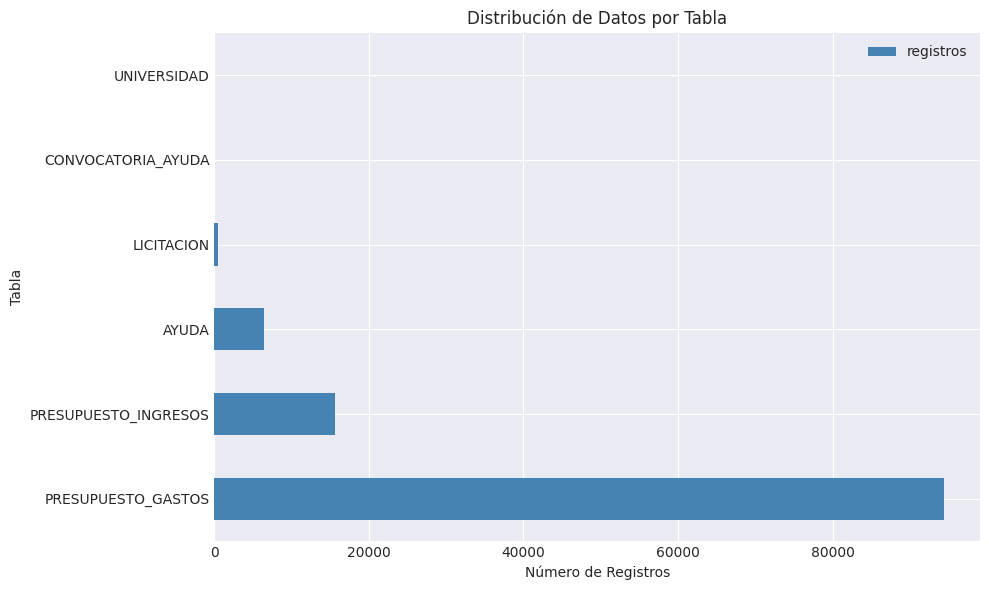

In [32]:
# Visualización del resumen
fig, ax = plt.subplots(figsize=(10, 6))
df_resumen.plot(x='tabla', y='registros', kind='barh', ax=ax, color='steelblue')
ax.set_xlabel('Número de Registros')
ax.set_ylabel('Tabla')
ax.set_title('Distribución de Datos por Tabla')
plt.tight_layout()
plt.show()

## 2. Análisis de Presupuestos

### 2.1 Evolución del Presupuesto por Año

In [33]:
# Presupuesto total por año (gastos e ingresos)
query = """
SELECT 
    anio,
    SUM(credito_total) as total_gastos
FROM presupuesto_gastos
WHERE anio IS NOT NULL
GROUP BY anio
ORDER BY anio;
"""

df_gastos_anio = pd.read_sql_query(query, conn)

query = """
SELECT 
    anio,
    SUM(credito_total) as total_ingresos
FROM presupuesto_ingresos
WHERE anio IS NOT NULL
GROUP BY anio
ORDER BY anio;
"""

df_ingresos_anio = pd.read_sql_query(query, conn)

# Combinar gastos e ingresos
df_presupuesto = pd.merge(df_gastos_anio, df_ingresos_anio, on='anio', how='outer')
df_presupuesto = df_presupuesto.fillna(0)
df_presupuesto

/tmp/ipykernel_35935/3298943761.py:12: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_gastos_anio = pd.read_sql_query(query, conn)
/tmp/ipykernel_35935/3298943761.py:24: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_ingresos_anio = pd.read_sql_query(query, conn)


,anio,total_gastos,total_ingresos
0,2017,2.883932e+08,2.883932e+08
1,2018,2.954302e+08,2.954302e+08
2,2019,3.154899e+08,3.154899e+08
3,2020,3.260863e+08,3.260863e+08
4,2021,6.813788e+08,6.813788e+08
5,2022,7.784233e+08,7.784233e+08
6,2023,7.926207e+08,7.935096e+08
7,2024,7.862313e+08,7.862313e+08
8,2025,3.314761e+08,3.314761e+08


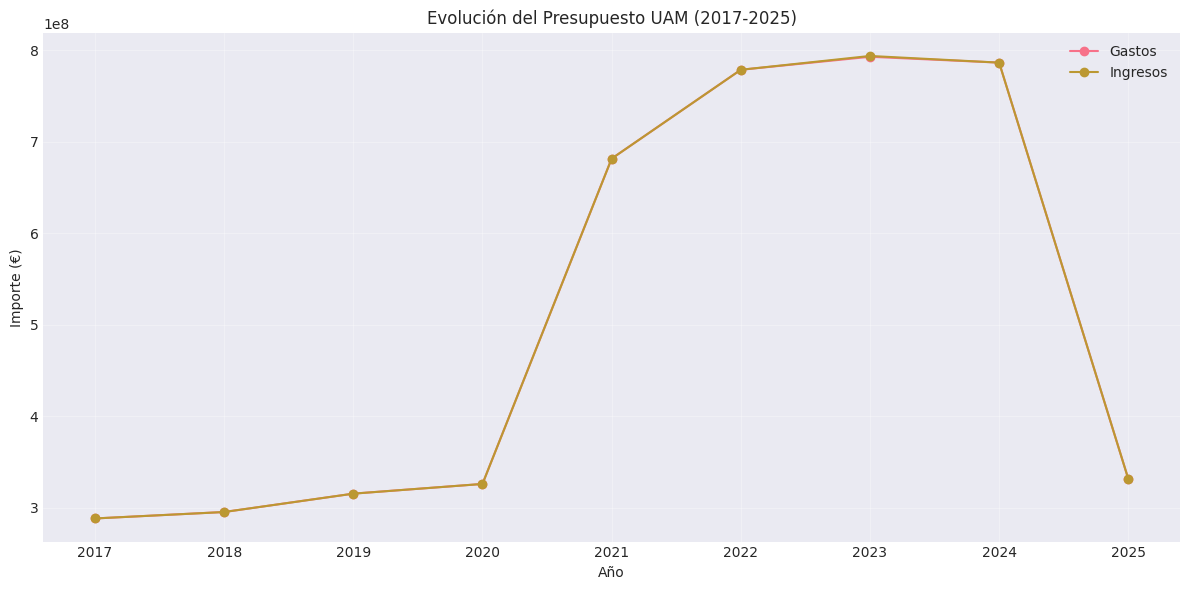

In [34]:
# Visualización de la evolución
fig, ax = plt.subplots(figsize=(12, 6))
df_presupuesto.plot(x='anio', y=['total_gastos', 'total_ingresos'], ax=ax, marker='o')
ax.set_xlabel('Año')
ax.set_ylabel('Importe (€)')
ax.set_title('Evolución del Presupuesto UAM (2017-2025)')
ax.legend(['Gastos', 'Ingresos'])
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### 2.2 Distribución de Gastos por Capítulo

In [35]:
# Top 10 capítulos de gastos
query = """
SELECT 
    des_capitulo,
    SUM(credito_total) as total
FROM presupuesto_gastos
WHERE des_capitulo IS NOT NULL AND des_capitulo != ''
GROUP BY des_capitulo
ORDER BY total DESC
LIMIT 10;
"""

df_capitulos = pd.read_sql_query(query, conn)
df_capitulos['total_millones'] = df_capitulos['total'] / 1_000_000
df_capitulos

/tmp/ipykernel_35935/1459475222.py:13: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_capitulos = pd.read_sql_query(query, conn)


,des_capitulo,total,total_millones
0,GASTOS DE PERSONAL,2.227831e+09,2227.830906
1,INVERSIONES REALES,1.402882e+09,1402.882338
2,GASTOS CORRIENTES EN BIENES Y SERVICIOS,5.907128e+08,590.712793
3,TRANSFERENCIAS CORRIENTES,2.008610e+08,200.860989
4,TRANSFERENCIAS DE CAPITAL,1.318575e+08,131.857460
5,PASIVOS FINANCIEROS,3.126474e+07,31.264736
6,ACTIVOS FINANCIEROS,6.500000e+06,6.500000
7,GASTOS FINANCIEROS,3.620640e+06,3.620640


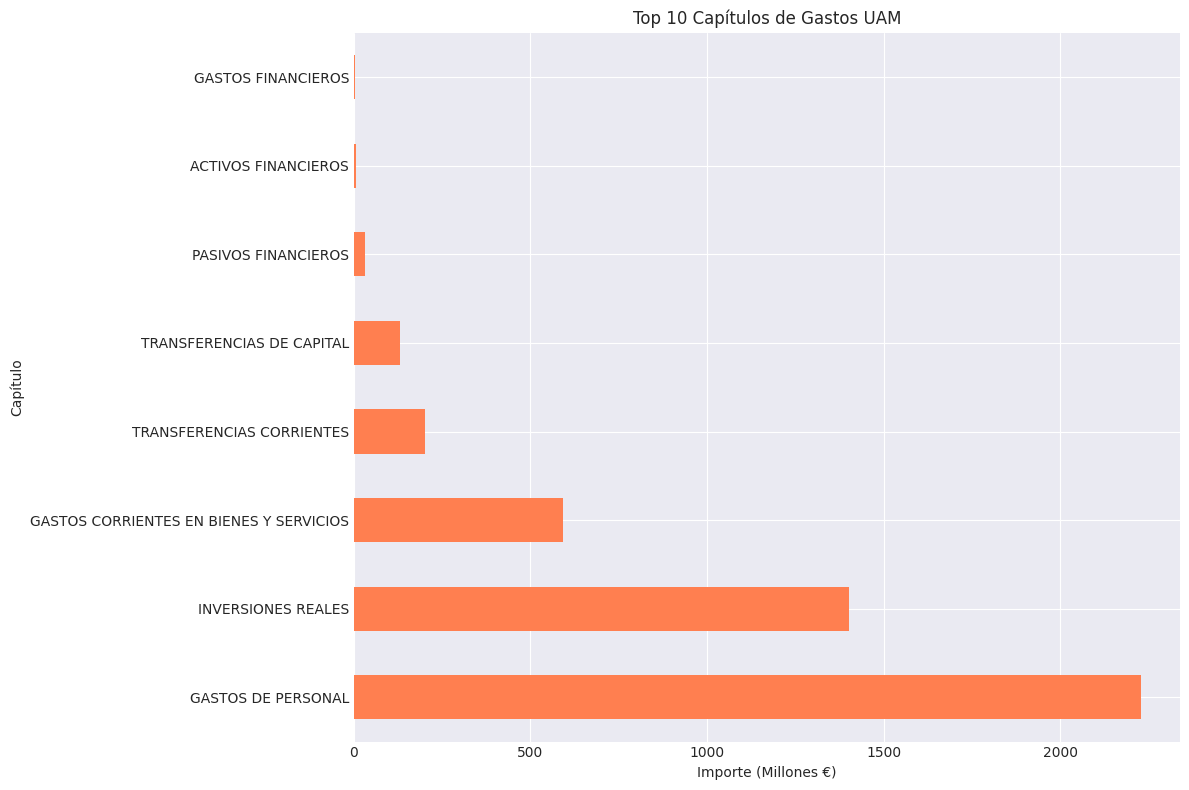

In [36]:
# Gráfico de barras de los principales capítulos
fig, ax = plt.subplots(figsize=(12, 8))
df_capitulos.plot(x='des_capitulo', y='total_millones', kind='barh', ax=ax, color='coral')
ax.set_xlabel('Importe (Millones €)')
ax.set_ylabel('Capítulo')
ax.set_title('Top 10 Capítulos de Gastos UAM')
ax.legend().remove()
plt.tight_layout()
plt.show()

## 3. Análisis de Ayudas y Convocatorias

### 3.1 Estadísticas de Ayudas

In [37]:
# Estadísticas de ayudas por categoría
query = """
SELECT 
    c.des_categoria,
    COUNT(a.id_ayuda) as num_ayudas,
    SUM(a.cuantia_total) as total_cuantia,
    AVG(a.cuantia_total) as media_cuantia,
    MAX(a.cuantia_total) as max_cuantia
FROM ayuda a
JOIN convocatoria_ayuda c ON a.cod_convocatoria_ayuda = c.cod_convocatoria
WHERE c.des_categoria IS NOT NULL AND c.des_categoria != ''
GROUP BY c.des_categoria
ORDER BY total_cuantia DESC;
"""

df_ayudas_cat = pd.read_sql_query(query, conn)
df_ayudas_cat

/tmp/ipykernel_35935/2942108398.py:16: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_ayudas_cat = pd.read_sql_query(query, conn)


,des_categoria,num_ayudas,total_cuantia,media_cuantia,max_cuantia
0,Formación de investigadores e investigadoras,2216,16275941.70,7344.739034,22031.52
1,Becas y ayudas,2963,6599877.64,2227.430861,9444.20
2,Colaboración,1211,322040.00,265.928984,1800.00


In [38]:
# Top 10 ayudas más cuantiosas
query = """
SELECT 
    c.nombre_convocatoria,
    c.des_categoria,
    a.cuantia_total,
    c.fecha_inicio_solicitudes,
    c.fecha_fin_solicitudes
FROM ayuda a
JOIN convocatoria_ayuda c ON a.cod_convocatoria_ayuda = c.cod_convocatoria
WHERE a.cuantia_total IS NOT NULL
ORDER BY a.cuantia_total DESC
LIMIT 10;
"""

df_top_ayudas = pd.read_sql_query(query, conn)
df_top_ayudas

/tmp/ipykernel_35935/2199746243.py:16: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_top_ayudas = pd.read_sql_query(query, conn)


,nombre_convocatoria,des_categoria,cuantia_total,fecha_inicio_solicitudes,fecha_fin_solicitudes
0,Convocatoria del Programa Propio de Ayudas par...,Formación de investigadores e investigadoras,22031.52,2017-04-05,2017-04-20
1,Convocatoria del Programa Propio de Ayudas par...,Formación de investigadores e investigadoras,22031.52,2017-04-05,2017-04-20
2,Convocatoria del Programa Propio de Ayudas par...,Formación de investigadores e investigadoras,22031.52,2017-04-05,2017-04-20
3,Convocatoria del Programa Propio de Ayudas par...,Formación de investigadores e investigadoras,22031.52,2017-04-05,2017-04-20
4,Convocatoria del Programa Propio de Ayudas par...,Formación de investigadores e investigadoras,22031.52,2017-04-05,2017-04-20
5,Convocatoria del Programa Propio de Ayudas par...,Formación de investigadores e investigadoras,22031.52,2017-04-05,2017-04-20
6,Convocatoria del Programa Propio de Ayudas par...,Formación de investigadores e investigadoras,22031.52,2017-04-05,2017-04-20
7,Convocatoria del Programa Propio de Ayudas par...,Formación de investigadores e investigadoras,22031.52,2017-04-05,2017-04-20
8,Convocatoria del Programa Propio de Ayudas par...,Formación de investigadores e investigadoras,22031.52,2017-04-05,2017-04-20
9,Convocatoria del Programa Propio de Ayudas par...,Formación de investigadores e investigadoras,22031.52,2017-04-05,2017-04-20


### 3.2 Distribución de Cuantías de Ayudas

/tmp/ipykernel_35935/2083866062.py:8: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_cuantias = pd.read_sql_query(query, conn)


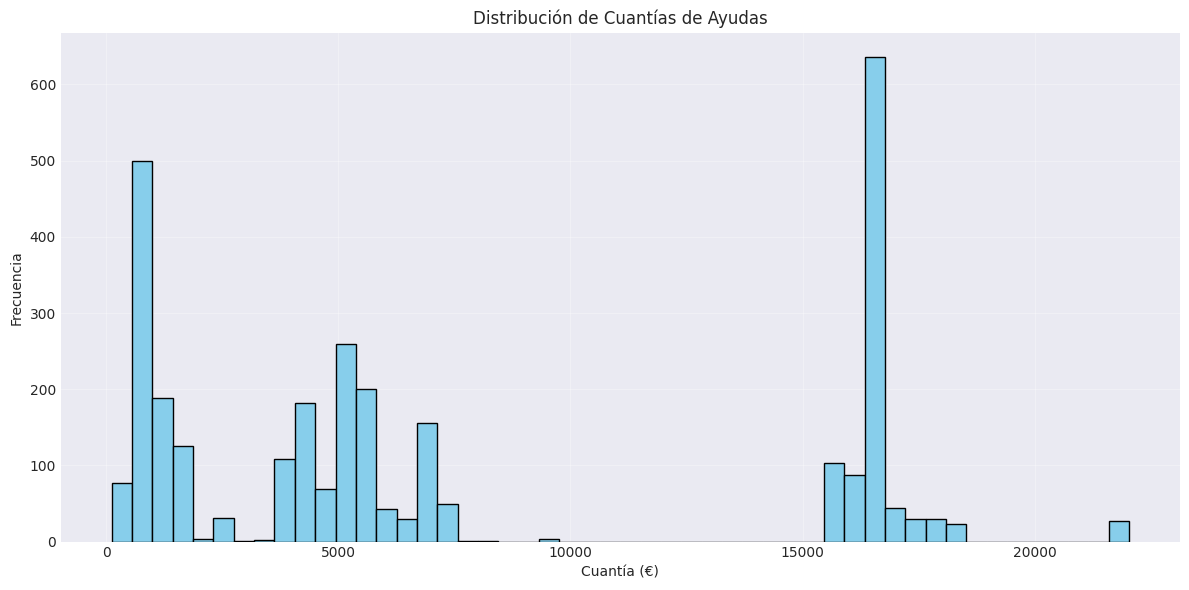


Estadísticas de cuantías:
count     3008.000000
mean      7712.054302
std       6513.465328
min        120.000000
25%       1277.420000
50%       5278.540000
75%      16422.000000
max      22031.520000
Name: cuantia_total, dtype: float64


In [39]:
# Histograma de cuantías
query = """
SELECT cuantia_total 
FROM ayuda 
WHERE cuantia_total IS NOT NULL AND cuantia_total > 0;
"""

df_cuantias = pd.read_sql_query(query, conn)

fig, ax = plt.subplots(figsize=(12, 6))
df_cuantias['cuantia_total'].hist(bins=50, ax=ax, color='skyblue', edgecolor='black')
ax.set_xlabel('Cuantía (€)')
ax.set_ylabel('Frecuencia')
ax.set_title('Distribución de Cuantías de Ayudas')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nEstadísticas de cuantías:")
print(df_cuantias['cuantia_total'].describe())

## 4. Análisis de Licitaciones

### 4.1 Top Licitaciones por Importe

In [40]:
# Top 10 licitaciones más grandes
query = """
SELECT 
    identificador,
    objeto_licitacion_o_lote,
    presupuesto_base_sin_impuestos_licitacion_o_lote as presupuesto_base,
    importe_adjudicacion_sin_impuestos_licitacion_o_lote as importe_adjudicacion,
    resultado_licitacion_o_lote,
    primera_publicacion
FROM licitacion
WHERE importe_adjudicacion_sin_impuestos_licitacion_o_lote IS NOT NULL
ORDER BY importe_adjudicacion_sin_impuestos_licitacion_o_lote DESC
LIMIT 10;
"""

df_top_licitaciones = pd.read_sql_query(query, conn)
df_top_licitaciones

/tmp/ipykernel_35935/4129490010.py:16: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_top_licitaciones = pd.read_sql_query(query, conn)


,identificador,objeto_licitacion_o_lote,presupuesto_base,importe_adjudicacion,resultado_licitacion_o_lote,primera_publicacion
0,16195599,Limpieza de los edificios y demás dependencias...,4714704.39,4203785.54,Formalizado,2024-12-01
1,6225549,"servicio de limpieza, desratización y desinsec...",4555723.59,4047415.06,Adjudicado,2020-08-04
2,11449629,Limpieza de los edificios y demás dependencias...,4893616.58,3988294.18,Formalizado,2022-10-28
3,2485298,"Servicio de limpieza, desinfección, desratizac...",4221480.00,3885994.36,Adjudicado,2018-10-01
4,3916214,Servicio de mantenimiento de los edificios e i...,3701790.64,3198057.00,Adjudicado,2019-07-30
5,9128722,“Servicio de mantenimiento de los edificios e ...,3173513.42,2727439.00,Adjudicado,2022-01-21
6,9265468,Suministro eléctrico en alta tensión (AT),3541662.15,2669540.46,Adjudicado,2022-02-09
7,3470150,Concesión de servicios para la gestión y explo...,2700000.00,2481552.00,Adjudicado,2019-04-10
8,4084460,Contratación de un servicio de seguridad en la...,1776877.18,1655900.00,Adjudicado,2019-09-25
9,15406888,Lote 1: Mantenimiento y soporte de los equipos...,1653000.00,1652900.00,Formalizado,2024-07-28


### 4.2 Estadísticas de Licitaciones por Resultado

In [41]:
# Distribución por resultado
query = """
SELECT 
    resultado_licitacion_o_lote,
    COUNT(*) as num_licitaciones,
    SUM(importe_adjudicacion_sin_impuestos_licitacion_o_lote) as total_adjudicado
FROM licitacion
WHERE resultado_licitacion_o_lote IS NOT NULL
GROUP BY resultado_licitacion_o_lote
ORDER BY num_licitaciones DESC;
"""

df_resultados = pd.read_sql_query(query, conn)
df_resultados

/tmp/ipykernel_35935/914960591.py:13: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_resultados = pd.read_sql_query(query, conn)


,resultado_licitacion_o_lote,num_licitaciones,total_adjudicado
0,Adjudicado,218,48101387.82
1,Formalizado,178,37488690.53
2,Desierto,30,NaN
3,Desistimiento,5,NaN
4,Renuncia,2,NaN


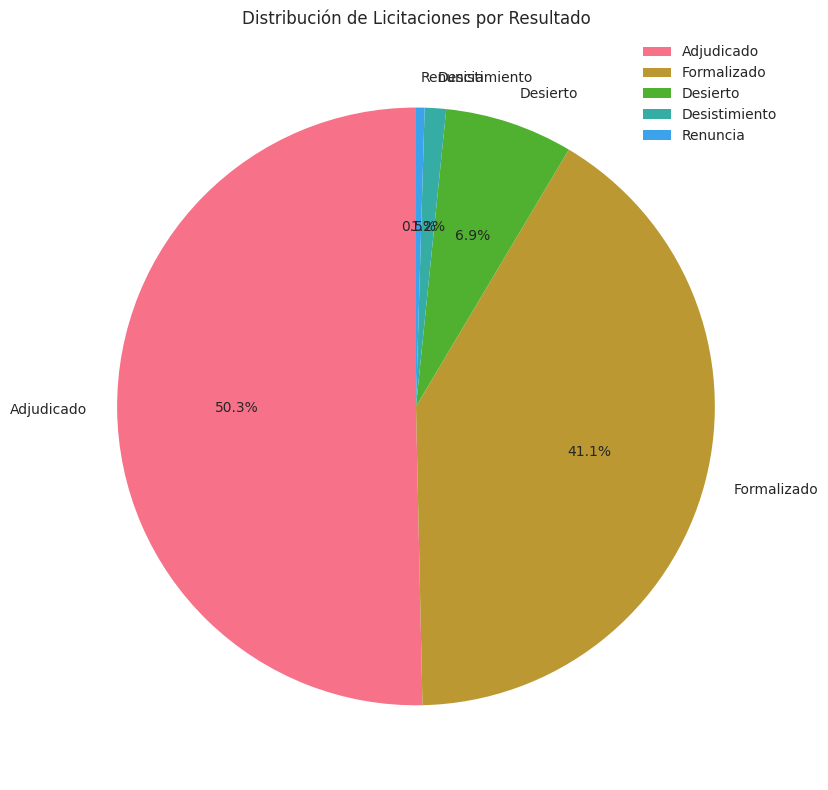

In [42]:
# Gráfico de pie de resultados
fig, ax = plt.subplots(figsize=(10, 8))
df_resultados.plot(
    y='num_licitaciones', 
    kind='pie', 
    labels=df_resultados['resultado_licitacion_o_lote'],
    ax=ax,
    autopct='%1.1f%%',
    startangle=90
)
ax.set_ylabel('')
ax.set_title('Distribución de Licitaciones por Resultado')
plt.tight_layout()
plt.show()

### 4.3 Evolución de Licitaciones en el Tiempo

/tmp/ipykernel_35935/388234494.py:13: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_licit_anio = pd.read_sql_query(query, conn)


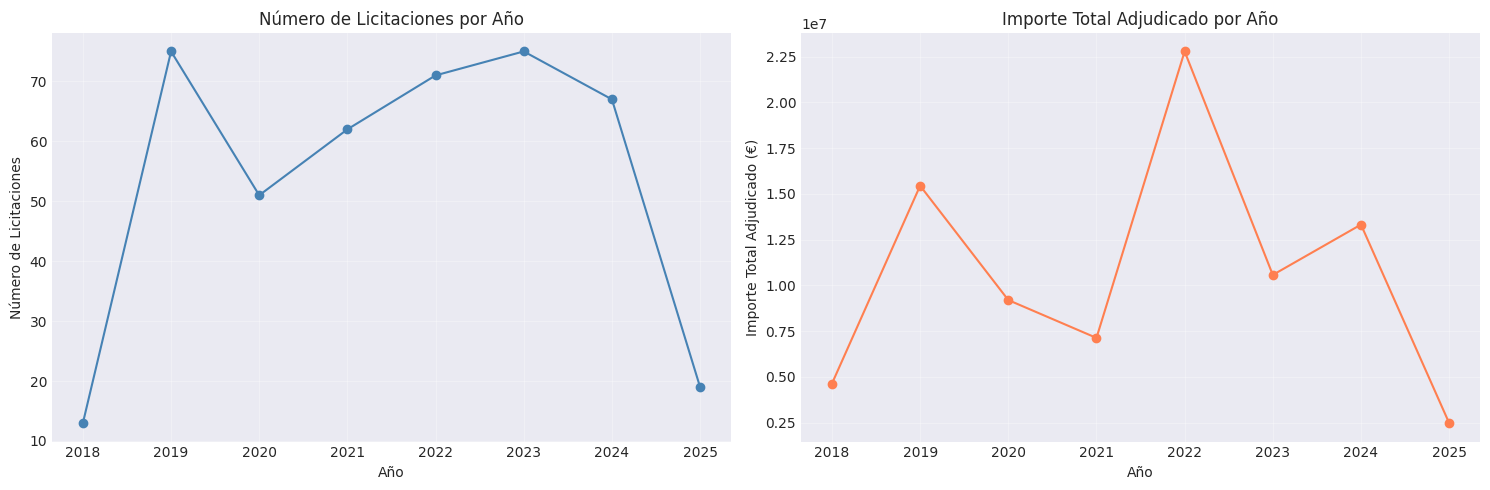

In [43]:
# Licitaciones por año
query = """
SELECT 
    EXTRACT(YEAR FROM primera_publicacion) as anio,
    COUNT(*) as num_licitaciones,
    SUM(importe_adjudicacion_sin_impuestos_licitacion_o_lote) as total_adjudicado
FROM licitacion
WHERE primera_publicacion IS NOT NULL
GROUP BY EXTRACT(YEAR FROM primera_publicacion)
ORDER BY anio;
"""

df_licit_anio = pd.read_sql_query(query, conn)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Gráfico 1: Número de licitaciones
df_licit_anio.plot(x='anio', y='num_licitaciones', ax=ax1, marker='o', color='steelblue')
ax1.set_xlabel('Año')
ax1.set_ylabel('Número de Licitaciones')
ax1.set_title('Número de Licitaciones por Año')
ax1.grid(True, alpha=0.3)
ax1.legend().remove()

# Gráfico 2: Importe total adjudicado
df_licit_anio.plot(x='anio', y='total_adjudicado', ax=ax2, marker='o', color='coral')
ax2.set_xlabel('Año')
ax2.set_ylabel('Importe Total Adjudicado (€)')
ax2.set_title('Importe Total Adjudicado por Año')
ax2.grid(True, alpha=0.3)
ax2.legend().remove()

plt.tight_layout()
plt.show()

## 5. Consultas Personalizadas

### 5.1 SPARQL en GraphDB

Configuración y consultas SPARQL contra el repositorio de GraphDB.

In [44]:
# Configuración de GraphDB y SPARQL
from SPARQLWrapper import SPARQLWrapper, JSON

GRAPHDB_URL = "http://localhost:8000"
REPOSITORY = "uam_data"  # Ajusta si el nombre difiere
SPARQL_ENDPOINT = f"{GRAPHDB_URL}/repositories/{REPOSITORY}"

sparql = SPARQLWrapper(SPARQL_ENDPOINT)
sparql.setReturnFormat(JSON)
print(f"✅ Endpoint SPARQL configurado: {SPARQL_ENDPOINT}")

✅ Endpoint SPARQL configurado: http://localhost:8000/repositories/uam_data


In [45]:
# Instalar dependencias para SPARQL (si es necesario)
# %pip install SPARQLWrapper

In [46]:
# Comparación: misma consulta en SQL y SPARQL

print("="*60)
print("COMPARACIÓN SQL vs SPARQL")
print("="*60)

# Consulta SQL: Total de gastos por año
sql_query = """
SELECT anio, COUNT(*) as registros, SUM(credito_total) as total
FROM presupuesto_gastos
WHERE anio IS NOT NULL
GROUP BY anio
ORDER BY anio
LIMIT 5;
"""

print("\n🔵 SQL Query:")
print(sql_query)
df_sql_result = pd.read_sql_query(sql_query, conn)
print("\nResultado SQL:")
display(df_sql_result)

# Consulta SPARQL equivalente con provenance -> Distribution -> añoFiscal
sparql_query = """
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX schema: <https://schema.org/>
PREFIX g2_ont: <https://www.mi-master.es/proyecto/ontologia#>
PREFIX g2_data: <https://www.mi-master.es/proyecto/datos/>
PREFIX dcterms: <http://purl.org/dc/terms/>
PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>

SELECT ?anio (COUNT(?gasto) as ?registros) (SUM(xsd:decimal(?credito)) as ?total)
WHERE {
  ?gasto rdf:type g2_ont:PartidaGasto ;
        schema:amount ?amountNode ;
        dcterms:provenance ?dist .
  ?amountNode schema:value ?credito .
  ?dist g2_ont:añoFiscal ?anio .
}
GROUP BY ?anio
ORDER BY ?anio
LIMIT 5
"""

print("\n🟢 SPARQL Query (Ontología UAM):")
print(sparql_query)

try:
    sparql.setQuery(sparql_query)
    results = sparql.query().convert()
    bindings = results["results"]["bindings"]
    
    if bindings:
        df_sparql_result = pd.DataFrame([
            {
                'anio': r.get('anio', {}).get('value', ''),
                'registros': int(r.get('registros', {}).get('value', 0)),
                'total': float(r.get('total', {}).get('value', 0))
            }
            for r in bindings
        ])
        print("\nResultado SPARQL:")
        display(df_sparql_result)
        
        print("\n📊 Comparación:")
        print(f"SQL retorna: {len(df_sql_result)} filas")
        print(f"SPARQL retorna: {len(df_sparql_result)} filas")
    else:
        print("\n⚠️ SPARQL no retornó resultados (verifica que los datos estén cargados en GraphDB)")
except Exception as e:
    print(f"\n❌ Error en consulta SPARQL: {e}")
    print("   (Verifica que GraphDB esté corriendo y el repositorio exista)")

print("\n" + "="*60)

COMPARACIÓN SQL vs SPARQL

🔵 SQL Query:

SELECT anio, COUNT(*) as registros, SUM(credito_total) as total
FROM presupuesto_gastos
WHERE anio IS NOT NULL
GROUP BY anio
ORDER BY anio
LIMIT 5;


Resultado SQL:


/tmp/ipykernel_35935/1336440131.py:19: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_sql_result = pd.read_sql_query(sql_query, conn)


,anio,registros,total
0,2017,8251,2.883932e+08
1,2018,8346,2.954302e+08
2,2019,8179,3.154899e+08
3,2020,15559,3.260863e+08
4,2021,8859,6.813788e+08



🟢 SPARQL Query (Ontología UAM):

PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX schema: <https://schema.org/>
PREFIX g2_ont: <https://www.mi-master.es/proyecto/ontologia#>
PREFIX g2_data: <https://www.mi-master.es/proyecto/datos/>
PREFIX dcterms: <http://purl.org/dc/terms/>
PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>

SELECT ?anio (COUNT(?gasto) as ?registros) (SUM(xsd:decimal(?credito)) as ?total)
WHERE {
  ?gasto rdf:type g2_ont:PartidaGasto ;
        schema:amount ?amountNode ;
        dcterms:provenance ?dist .
  ?amountNode schema:value ?credito .
  ?dist g2_ont:añoFiscal ?anio .
}
GROUP BY ?anio
ORDER BY ?anio
LIMIT 5


⚠️ SPARQL no retornó resultados (verifica que los datos estén cargados en GraphDB)



#### Consulta 1: Comparación SQL vs SPARQL

In [47]:
# Consulta SPARQL con filtros y regex - ACTUALIZADA
query_filter = """
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX schema: <https://schema.org/>
PREFIX dcterms: <http://purl.org/dc/terms/>
PREFIX g2_ont: <https://www.mi-master.es/proyecto/ontologia#>

SELECT ?licitacion ?objeto ?importe ?fecha
WHERE {
  ?licitacion rdf:type g2_ont:Licitacion .
  ?licitacion dcterms:description ?objeto .
  ?licitacion schema:amount ?amountNode .
  ?amountNode schema:value ?importe .
  OPTIONAL { ?licitacion schema:url ?fecha } .
  
  FILTER(REGEX(?objeto, "software|informática|tecnología", "i"))
  FILTER(?importe > 10000)
}
ORDER BY DESC(?importe)
LIMIT 10
"""

try:
    sparql.setQuery(query_filter)
    results = sparql.query().convert()
    
    bindings = results["results"]["bindings"]
    if bindings:
        df_licit_sparql = pd.DataFrame([
            {
                'objeto': r.get('objeto', {}).get('value', 'N/A')[:60] + '...',
                'importe': float(r.get('importe', {}).get('value', 0)),
                'fecha': r.get('fecha', {}).get('value', 'N/A')
            }
            for r in bindings
        ])
        print(f"✅ Encontradas {len(df_licit_sparql)} licitaciones de tecnología")
        display(df_licit_sparql)
    else:
        print("⚠️ No se encontraron licitaciones con los criterios especificados.")
except Exception as e:
    print(f"❌ Error: {e}")

⚠️ No se encontraron licitaciones con los criterios especificados.


#### Consulta 2: SPARQL con FILTER y expresiones regulares

In [48]:
# Consulta SPARQL con agregación - ACTUALIZADA
query_agregacion = """
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX schema: <https://schema.org/>
PREFIX g2_ont: <https://www.mi-master.es/proyecto/ontologia#>

SELECT ?capitulo (SUM(?credito) as ?total) (COUNT(?presupuesto) as ?numRegistros)
WHERE {
  ?presupuesto rdf:type g2_ont:PartidaGasto .
  ?presupuesto g2_ont:capitulo ?capitulo .
  ?presupuesto schema:amount ?amountNode .
  ?amountNode schema:value ?credito .
}
GROUP BY ?capitulo
ORDER BY DESC(?total)
LIMIT 10
"""

try:
    sparql.setQuery(query_agregacion)
    results = sparql.query().convert()
    
    bindings = results["results"]["bindings"]
    if bindings:
        df_agregacion = pd.DataFrame([
            {
                'capitulo': r.get('capitulo', {}).get('value', 'N/A'),
                'total': float(r.get('total', {}).get('value', 0)),
                'num_registros': int(r.get('numRegistros', {}).get('value', 0))
            }
            for r in bindings
        ])
        df_agregacion['total_millones'] = df_agregacion['total'] / 1_000_000
        print(f"✅ Agregación completada: {len(df_agregacion)} capítulos")
        display(df_agregacion[['capitulo', 'total_millones', 'num_registros']])
        
        # Visualización
        fig, ax = plt.subplots(figsize=(12, 6))
        df_agregacion.plot(x='capitulo', y='total_millones', kind='barh', ax=ax, color='mediumseagreen')
        ax.set_xlabel('Total (Millones €)')
        ax.set_ylabel('Capítulo')
        ax.set_title('Agregación SPARQL: Total por Capítulo')
        ax.legend().remove()
        plt.tight_layout()
        plt.show()
    else:
        print("⚠️ No se pudieron agregar datos.")
except Exception as e:
    print(f"❌ Error: {e}")

⚠️ No se pudieron agregar datos.


#### Consulta 3: Agregación SPARQL - Total por Capítulo

In [49]:
# Consulta SPARQL: ayudas con sus convocatorias - ACTUALIZADA
query_ayudas = """
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX schema: <https://schema.org/>
PREFIX dcterms: <http://purl.org/dc/terms/>
PREFIX g2_ont: <https://www.mi-master.es/proyecto/ontologia#>

SELECT ?ayuda ?convocatoria ?nombreConv ?categoria ?cuantia
WHERE {
  ?ayuda rdf:type g2_ont:AyudaConcedida .
  ?ayuda g2_ont:convocatoriaAsociada ?convocatoria .
  ?ayuda schema:amount ?amountNode .
  ?amountNode schema:value ?cuantia .
  
  ?convocatoria schema:name ?nombreConv .
  OPTIONAL { ?convocatoria dcterms:description ?categoria } .
  
  FILTER(?cuantia > 0)
}
ORDER BY DESC(?cuantia)
LIMIT 10
"""

try:
    sparql.setQuery(query_ayudas)
    results = sparql.query().convert()
    
    bindings = results["results"]["bindings"]
    if bindings:
        df_ayudas_sparql = pd.DataFrame([
            {
                'convocatoria': r.get('nombreConv', {}).get('value', 'N/A'),
                'categoria': r.get('categoria', {}).get('value', 'N/A'),
                'cuantia': float(r.get('cuantia', {}).get('value', 0))
            }
            for r in bindings
        ])
        print(f"✅ Encontradas {len(df_ayudas_sparql)} ayudas")
        display(df_ayudas_sparql)
    else:
        print("⚠️ No se encontraron ayudas en el grafo.")
except Exception as e:
    print(f"❌ Error: {e}")

⚠️ No se encontraron ayudas en el grafo.


#### Consulta 4: Ayudas y sus convocatorias (SPARQL JOIN)

In [50]:
# Consulta SPARQL: presupuestos de gastos - ACTUALIZADA (usando provenance -> añoFiscal)
query_presupuestos = """
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX schema: <https://schema.org/>
PREFIX dcterms: <http://purl.org/dc/terms/>
PREFIX g2_ont: <https://www.mi-master.es/proyecto/ontologia#>
PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>

SELECT ?presupuesto ?anio ?capitulo ?creditoTotal
WHERE {
  ?presupuesto rdf:type g2_ont:PartidaGasto ;
               g2_ont:capitulo ?capitulo ;
               schema:amount ?amountNode ;
               dcterms:provenance ?dist .
  ?amountNode schema:value ?creditoTotal .
  ?dist g2_ont:añoFiscal ?anio .
  
  FILTER(?creditoTotal > 1000000)
}
ORDER BY DESC(?creditoTotal)
LIMIT 15
"""

try:
    sparql.setQuery(query_presupuestos)
    results = sparql.query().convert()
    
    bindings = results["results"]["bindings"]
    if bindings:
        df_presu_sparql = pd.DataFrame([
            {
                'año': r.get('anio', {}).get('value', ''),
                'capitulo': r.get('capitulo', {}).get('value', ''),
                'credito_total': float(r.get('creditoTotal', {}).get('value', 0))
            }
            for r in bindings
        ])
        df_presu_sparql['credito_millones'] = df_presu_sparql['credito_total'] / 1_000_000
        print(f"✅ Encontrados {len(df_presu_sparql)} presupuestos > 1M€")
        display(df_presu_sparql)
    else:
        print("⚠️ No se encontraron presupuestos en el grafo.")
except Exception as e:
    print(f"❌ Error: {e}")

⚠️ No se encontraron presupuestos en el grafo.


#### Consulta 5: Presupuestos relacionados con la UAM

In [51]:
# Consulta SPARQL: buscar universidades - ACTUALIZADA
query_universidades = """
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX schema: <https://schema.org/>
PREFIX dcterms: <http://purl.org/dc/terms/>
PREFIX g2_ont: <https://www.mi-master.es/proyecto/ontologia#>
PREFIX owl: <http://www.w3.org/2002/07/owl#>

SELECT ?universidad ?nombre ?codigo ?vatID ?wikidata ?dbpedia
WHERE {
  ?universidad rdf:type g2_ont:Universidad .
  OPTIONAL { ?universidad schema:name ?nombre } .
  OPTIONAL { ?universidad dcterms:identifier ?codigo } .
  OPTIONAL { ?universidad schema:vatID ?vatID } .
  OPTIONAL { 
    ?universidad owl:sameAs ?externalLink .
    FILTER(CONTAINS(STR(?externalLink), "wikidata"))
    BIND(?externalLink as ?wikidata)
  }
  OPTIONAL { 
    ?universidad owl:sameAs ?externalLink2 .
    FILTER(CONTAINS(STR(?externalLink2), "dbpedia"))
    BIND(?externalLink2 as ?dbpedia)
  }
}
"""

try:
    sparql.setQuery(query_universidades)
    results = sparql.query().convert()
    
    bindings = results["results"]["bindings"]
    if bindings:
        df_unis = pd.DataFrame([
            {
                'universidad': r.get('universidad', {}).get('value', ''),
                'nombre': r.get('nombre', {}).get('value', 'N/A'),
                'codigo': r.get('codigo', {}).get('value', 'N/A'),
                'vatID': r.get('vatID', {}).get('value', 'N/A'),
                'wikidata': r.get('wikidata', {}).get('value', 'N/A'),
                'dbpedia': r.get('dbpedia', {}).get('value', 'N/A')
            }
            for r in bindings
        ])
        print(f"✅ Encontradas {len(df_unis)} universidades")
        display(df_unis)
    else:
        print("⚠️ No se encontraron universidades en el grafo.")
except Exception as e:
    print(f"❌ Error: {e}")

⚠️ No se encontraron universidades en el grafo.


#### Consulta 6: Buscar entidades de tipo Universidad

In [52]:
# Consulta SPARQL básica: obtener todos los triples - ACTUALIZADA
query_all_triples = """
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX g2_ont: <https://www.mi-master.es/proyecto/ontologia#>
PREFIX g2_data: <https://www.mi-master.es/proyecto/datos/>
PREFIX g2_uni: <https://www.mi-master.es/proyecto/entidad/>

SELECT ?subject ?predicate ?object
WHERE {
  ?subject ?predicate ?object .
  # Filtrar solo triples de nuestro dominio
  FILTER(
    STRSTARTS(STR(?subject), STR(g2_data:)) ||
    STRSTARTS(STR(?subject), STR(g2_uni:)) ||
    STRSTARTS(STR(?subject), STR(g2_ont:))
  )
}
LIMIT 20
"""

try:
    sparql.setQuery(query_all_triples)
    results = sparql.query().convert()
    
    # Convertir a DataFrame
    bindings = results["results"]["bindings"]
    if bindings:
        df_triples = pd.DataFrame([
            {
                'subject': r['subject']['value'][-50:],  # Últimos 50 caracteres para mejor visualización
                'predicate': r['predicate']['value'].split('#')[-1].split('/')[-1],  # Solo el nombre de la propiedad
                'object': str(r['object']['value'])[:50]  # Primeros 50 caracteres
            }
            for r in bindings
        ])
        print(f"✅ Recuperados {len(df_triples)} triples de nuestra ontología")
        display(df_triples)
    else:
        print("⚠️ No se encontraron triples. Verifica que el repositorio tenga datos cargados.")
except Exception as e:
    print(f"❌ Error al consultar GraphDB: {e}")
    print(f"   Verifica que GraphDB esté ejecutándose en {GRAPHDB_URL}")
    print(f"   y que el repositorio '{REPOSITORY}' exista.")

⚠️ No se encontraron triples. Verifica que el repositorio tenga datos cargados.


#### Consulta 7: Listar todos los triples (limitado)

In [53]:
# Ejemplo: Buscar licitaciones relacionadas con "software" o "informática"
query = """
SELECT 
    objeto_licitacion_o_lote,
    importe_adjudicacion_sin_impuestos_licitacion_o_lote,
    resultado_licitacion_o_lote,
    primera_publicacion
FROM licitacion
WHERE LOWER(objeto_licitacion_o_lote) LIKE '%software%'
   OR LOWER(objeto_licitacion_o_lote) LIKE '%informática%'
   OR LOWER(objeto_licitacion_o_lote) LIKE '%informatica%'
ORDER BY importe_adjudicacion_sin_impuestos_licitacion_o_lote DESC NULLS LAST
LIMIT 10;
"""

df_software = pd.read_sql_query(query, conn)
print("\n Licitaciones relacionadas con Software/Informática:")
df_software


 Licitaciones relacionadas con Software/Informática:


/tmp/ipykernel_35935/2433924969.py:16: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_software = pd.read_sql_query(query, conn)


,objeto_licitacion_o_lote,importe_adjudicacion_sin_impuestos_licitacion_o_lote,resultado_licitacion_o_lote,primera_publicacion
0,Lote 1: Mantenimiento y soporte de los equipos...,1652900.00,Formalizado,2024-07-28
1,Servicio de mantenimiento y soporte de los equ...,1652000.00,Adjudicado,2019-07-31
2,Equipos de electrónica de red cableada y softw...,605163.97,Adjudicado,2021-11-02
3,Contratación del acuerdo denominado “Enterpris...,360000.00,Formalizado,2023-10-13
4,Contrato ELA para el mantenimiento del softwar...,262000.00,Adjudicado,2018-12-03
5,Quinientos treinta y ocho (538) ordenadores pe...,261102.16,Adjudicado,2019-03-13
6,Sistema de Microscopía Confocal de alta veloci...,210000.00,Adjudicado,2021-06-21
7,"Servicio de mantenimiento y soporte técnico, i...",152280.00,Adjudicado,2019-12-20
8,Servicio para realizar una actualización de la...,143865.55,Adjudicado,2019-07-12
9,Equipo analizador de adsorción de gases y vapo...,116450.00,Formalizado,2022-09-14


#### Consulta 8: Análisis de gastos vs ingresos por año

/tmp/ipykernel_35935/1552701897.py:15: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_balance = pd.read_sql_query(query, conn)


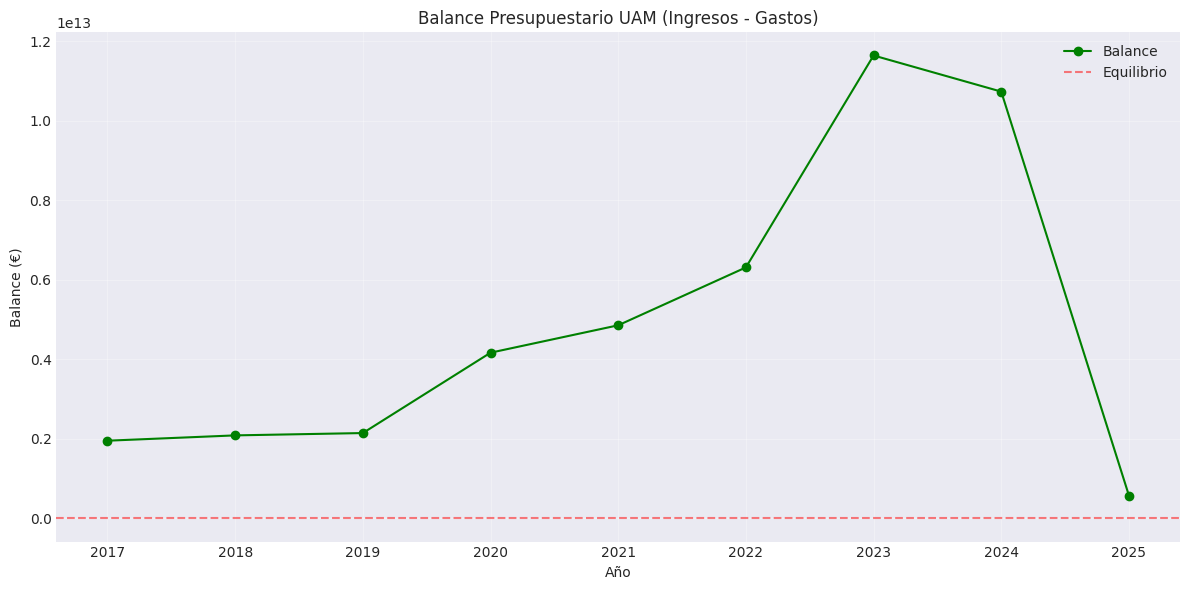

,anio,total_gastos,total_ingresos,balance
0,2017,4.256684e+11,2.379533e+12,1.953864e+12
1,2018,3.781507e+11,2.465661e+12,2.087510e+12
2,2019,4.344295e+11,2.580392e+12,2.145962e+12
3,2020,9.078244e+11,5.073577e+12,4.165753e+12
4,2021,1.181511e+12,6.036335e+12,4.854824e+12
5,2022,1.735884e+12,8.045004e+12,6.309120e+12
6,2023,1.681149e+12,1.331747e+13,1.163632e+13
7,2024,1.660521e+12,1.238865e+13,1.072813e+13
8,2025,1.823118e+11,7.580858e+11,5.757739e+11


In [54]:
# Análisis de gastos vs ingresos por año
query = """
SELECT 
    COALESCE(g.anio, i.anio) as anio,
    COALESCE(SUM(g.credito_total), 0) as total_gastos,
    COALESCE(SUM(i.credito_total), 0) as total_ingresos,
    COALESCE(SUM(i.credito_total), 0) - COALESCE(SUM(g.credito_total), 0) as balance
FROM presupuesto_gastos g
FULL OUTER JOIN presupuesto_ingresos i ON g.anio = i.anio
WHERE COALESCE(g.anio, i.anio) IS NOT NULL
GROUP BY COALESCE(g.anio, i.anio)
ORDER BY anio;
"""

df_balance = pd.read_sql_query(query, conn)

fig, ax = plt.subplots(figsize=(12, 6))
df_balance.plot(x='anio', y='balance', ax=ax, marker='o', color='green')
ax.axhline(y=0, color='red', linestyle='--', alpha=0.5)
ax.set_xlabel('Año')
ax.set_ylabel('Balance (€)')
ax.set_title('Balance Presupuestario UAM (Ingresos - Gastos)')
ax.grid(True, alpha=0.3)
ax.legend(['Balance', 'Equilibrio'])
plt.tight_layout()
plt.show()

df_balance

## 6. Consultas multi-lenguaje con pgvector

Configuración y consultas semánticas usando pgvector y embeddings

In [55]:
# Run a semantic query using the helper script in /scripts
import os, sys, subprocess

# Ensure the scripts directory is importable
scripts_path = os.path.abspath(os.path.join('..', 'scripts'))
if scripts_path not in sys.path:
    sys.path.insert(0, scripts_path)

# Import connect_db (will use env vars resolved below)
try:
    from pgvector_ingest_and_query import connect_db
except ImportError as e:
    raise ImportError(f"Could not import connect_db from {scripts_path}: {e}")

# Configure environment so connect_db can resolve host/port when running from host
os.environ['DB_HOST_PORT'] = os.environ.get('DB_HOST_PORT', '5432')
os.environ['POSTGRES_USER'] = os.environ.get('POSTGRES_USER', 'myuser')
os.environ['POSTGRES_PASSWORD'] = os.environ.get('POSTGRES_PASSWORD', 'mypassword')
os.environ['POSTGRES_DB'] = os.environ.get('POSTGRES_DB', 'mydb')
# Optional: print resolved connection hints
print('Connection hints:', {k: os.environ.get(k) for k in ('DB_HOST_PORT','POSTGRES_USER','POSTGRES_DB')})

# Attempt to connect (wrap so notebook doesn't crash on connection errors)
try:
    conn = connect_db()
    cur = conn.cursor()
    print('Connected to database successfully')
except Exception as e:
    print('Warning: could not open DB connection:', e)
    conn = None

# Run the external helper script as a subprocess so it uses the same env settings
script = os.path.join(scripts_path, 'pgvector_ingest_and_query.py')
# Query de ejemplo: "又稱數位憑證" (certificado digital en chino)
cmd = [sys.executable, script, 'query', '--q', '又稱數位憑證', '--k', '5', '--mode', 'transformer', '--model', 'paraphrase-multilingual-MiniLM-L12-v2']

try:
    # Explicitly request UTF-8 decoding and replace undecodable bytes to avoid UnicodeDecodeError on Windows
    res = subprocess.run(cmd, check=True, capture_output=True, text=True, encoding='utf-8', errors='replace')
    print(res.stdout)
    if res.stderr:
        print(res.stderr, file=sys.stderr)
except subprocess.CalledProcessError as e:
    print('Command failed:', e, file=sys.stderr)
    if e.stdout:
        print(e.stdout)
    if e.stderr:
        print(e.stderr, file=sys.stderr)


/home/pedro/MasterIA/GVD/hackathon_gbd/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Connection hints: {'DB_HOST_PORT': '5432', 'POSTGRES_USER': 'myuser', 'POSTGRES_DB': 'mydb'}
Connected to database successfully


DETAIL:  The database was created using collation version 2.41, but the operating system provides version 2.36.
HINT:  Rebuild all objects in this database that use the default collation and run ALTER DATABASE mydb REFRESH COLLATION VERSION, or build PostgreSQL with the right library version.
Command failed: Command '['/home/pedro/MasterIA/GVD/hackathon_gbd/.venv/bin/python', '/home/pedro/MasterIA/GVD/hackathon_gbd/scripts/pgvector_ingest_and_query.py', 'query', '--q', '又稱數位憑證', '--k', '5', '--mode', 'transformer', '--model', 'paraphrase-multilingual-MiniLM-L12-v2']' returned non-zero exit status 1.
sentence-transformers not installed. Install with 'pip install sentence-transformers' or use --mode dummy



## 7. Resumen Final

In [56]:
# Dashboard resumen
print("="*60)
print(" RESUMEN EJECUTIVO - DATOS UAM")
print("="*60)

# Total registros
total_registros = df_resumen['registros'].sum()
print(f"\ Total de registros procesados: {total_registros:,}")

# Rango temporal
anios = df_presupuesto['anio'].dropna().astype(int)
if len(anios) > 0:
    print(f" Período: {anios.min()} - {anios.max()} ({anios.max() - anios.min() + 1} años)")

# Presupuesto total
total_gastos = df_presupuesto['total_gastos'].sum()
total_ingresos = df_presupuesto['total_ingresos'].sum()
print(f"\n Presupuesto acumulado:")
print(f"   - Gastos: {total_gastos:,.2f} €")
print(f"   - Ingresos: {total_ingresos:,.2f} €")
print(f"   - Balance: {total_ingresos - total_gastos:,.2f} €")

# Ayudas
total_ayudas = df_ayudas_cat['num_ayudas'].sum()
total_cuantia_ayudas = df_ayudas_cat['total_cuantia'].sum()
print(f"\n Ayudas:")
print(f"   - Total concedidas: {total_ayudas:,}")
print(f"   - Cuantía total: {total_cuantia_ayudas:,.2f} €")
if total_ayudas > 0:
    print(f"   - Media por ayuda: {total_cuantia_ayudas/total_ayudas:,.2f} €")

# Licitaciones
total_licitaciones = df_resultados['num_licitaciones'].sum()
total_adjudicado = df_resultados['total_adjudicado'].sum()
print(f"\n Licitaciones:")
print(f"   - Total procesadas: {total_licitaciones:,}")
print(f"   - Importe total adjudicado: {total_adjudicado:,.2f} €")

print("\n" + "="*60)
print("✅ Análisis completado exitosamente")
print("="*60)

 RESUMEN EJECUTIVO - DATOS UAM
\ Total de registros procesados: 116,856
 Período: 2017 - 2025 (9 años)

 Presupuesto acumulado:
   - Gastos: 4,595,529,862.60 €
   - Ingresos: 4,596,418,751.96 €
   - Balance: 888,889.36 €

 Ayudas:
   - Total concedidas: 6,390
   - Cuantía total: 23,197,859.34 €
   - Media por ayuda: 3,630.34 €

 Licitaciones:
   - Total procesadas: 433
   - Importe total adjudicado: 85,590,078.35 €

✅ Análisis completado exitosamente


<>:8: SyntaxWarning: invalid escape sequence '\ '
<>:8: SyntaxWarning: invalid escape sequence '\ '
/tmp/ipykernel_35935/3715122083.py:8: SyntaxWarning: invalid escape sequence '\ '
  print(f"\ Total de registros procesados: {total_registros:,}")


## Cerrar Conexión

In [57]:
# Cerrar la conexión a la base de datos
conn.close()
print("✅ Conexión cerrada")

✅ Conexión cerrada
